# Menu <a class="anchor" id="menu"></a>

* [1. Préparatifs pour les algorithmes non-supervisés](#setup)

# Le data-drift

**TODO**

---
# Préparatifs 

In [1]:
import os
# import re
# import time
# import math
# import string
import datetime
# import unicodedata
# import json
from zipfile import ZipFile
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)
cmap_ref = 'nipy_spectral'

# import gc
# gc.enable()

In [2]:
data_customer = pd.read_csv(os.path.join('data', "olist_customers_dataset_clean.csv"))
data_orders = pd.read_csv(os.path.join('data', "olist_orders_dataset_clean.csv"))
data_items = pd.read_csv(os.path.join('data', "olist_order_items_dataset_clean.csv"))
data_payments = pd.read_csv(os.path.join('data', "olist_order_payments_dataset_clean.csv"))
data_reviews = pd.read_csv(os.path.join('data', "olist_order_reviews_dataset_clean.csv"))

---
---
# 1. Définition des fonctions génériques <a class="anchor" id="functions"></a> [⇪](#menu)

## 1.1 Feature Engineering <a class="anchor" id="functions_fe"></a> [⇪](#menu)

In [3]:
def str_to_date(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

def prepare_data(since, until, verbose=0):

    # Select the delivered orders using the provided purchase date range

    if(verbose > 0):
        print(f"\nSelection des commandes passées entre {since} et {until}")

    selection1 = data_orders[
        (data_orders.order_purchase_timestamp >= since) & 
        (data_orders.order_purchase_timestamp < until) & 
        (data_orders.order_status == 'delivered')][['order_id', 'customer_id', 'order_purchase_timestamp']]

    if(verbose > 1):
        display(selection1.head(2))
        display(selection1.shape)

    # Add the `customer_unique_id` using the temporary `customer_id`
    if(verbose > 0):
        print("\nAjout des ID unique des clients")

    selection2 = selection1.merge(data_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

    if(verbose > 1):
        display(selection2.head(2))
        display(selection2.shape)

    # Create a 'join' table that will be used for the various joints

    if(verbose > 0):
        print("\nCréation d'une table de jointure")

    data_base_join = selection2[['order_id', 'customer_id', 'customer_unique_id']]

    if (verbose > 1):
        display(data_base_join.head(2))
        display(data_base_join.shape)

    # Feature 1
    # Compute the `Recence` column for each order using the most recent provided date as reference

    if(verbose > 0):
        print("\nCalcul de la recence pour chaque commande")

    selection2.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(str_to_date)
    selection2['recence'] = selection2.order_purchase_timestamp - str_to_date(until)
    selection2['recence'] = selection2.recence.apply(lambda x: x.days)
    selection2.drop(columns=['order_purchase_timestamp'], inplace=True)

    if(verbose > 1):
        display(selection2.head(2))
        display(selection2.shape)

    # Collect the most recent `Recence` value for each customer

    if (verbose > 0):
        print("\nSelection de la plus petite valeur de recence pour chaque client")

    R_data = selection2[['customer_unique_id', 'recence']].groupby('customer_unique_id').min().reset_index()

    if (verbose > 1):
        display(R_data.head(2))
        display(R_data.shape)

    data_clustering = selection2[['customer_unique_id']].merge(R_data, on='customer_unique_id', how='left')

    # Feature 2
    # Compute the `Montant` column (total amount per order)

    if (verbose > 0):
        print("\nCalcul du montant total pour chaque commande")

    total_amount_per_order = selection2[['order_id']].merge(
        data_payments[['order_id', 'payment_value']], on='order_id', how='left'
    ).groupby('order_id').sum().reset_index()
    total_amount_per_order.rename(columns={'payment_value': 'montant'}, inplace=True)

    if (verbose > 1):
        display(total_amount_per_order.head(2))
        display(total_amount_per_order.shape)

    # Collect the sum of the `Montant` values for each customer

    if (verbose > 0):
        print("\nCalcul de la somme des montants de commandes pour chaque client")

    M_data = selection2[['customer_unique_id', 'order_id']].merge(
        total_amount_per_order, on='order_id', how='left'
    ).groupby('customer_unique_id').sum().reset_index()

    if (verbose > 1):
        display(M_data.head(2))
        display(M_data.shape)

    data_clustering = data_clustering.merge(M_data, on='customer_unique_id', how='left')

    # Feature 3
    # Fetch 'review_score', 'answer_days' for each order

    if (verbose > 0):
        print("\nRécupération des variables 'review_score', 'answer_days' pour chaque commande")

    data_fe = data_base_join.merge(
        data_reviews[['order_id', 'review_score', 'answer_days']].groupby('order_id').last(),
        on='order_id', how='left'
    )

    if (verbose > 1):
        display(data_fe.head(2))
        display(data_fe.shape)

    # Collect the 'review_score' and 'answer_days' means for each customer

    if (verbose > 0):
        print("\nCalcul des moyennes de 'review_score', 'answer_days' pour chaque client")

    data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()

    if (verbose > 1):
        display(data_fe2.head(2))
        display(data_fe2.shape)

    data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')

    # Feature 4 & 5
    # Collect the max value for 'order_item_id' (which is the number of items in the order)

    if (verbose > 0):
        print("\nRécupération de la valeur maximal de 'order_item_id' pour chaque commande")

    data_fe = data_items.groupby('order_id').last()[['order_item_id']].reset_index()
    data_fe = data_base_join.merge(data_fe, on='order_id', how='left')

    if (verbose > 1):
        display(data_fe.head(2))
        display(data_fe.shape)

    # Collect the 'order_item_id' mean for each customer

    if (verbose > 0):
        print("\nCalcul des moyennes de 'order_item_id' pour chaque client")

    data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
    data_fe2.rename(columns={'order_item_id': 'mean_items'}, inplace=True)

    if (verbose > 1):
        display(data_fe2.head(2))
        display(data_fe2.shape)

    # Collect the 'order_item_id' max value for each customer

    if (verbose > 0):
        print("\nCalcul de la valeur max de 'order_item_id' pour chaque client")

    data_fe3 = data_fe.groupby('customer_unique_id').sum().reset_index()
    data_fe3.rename(columns={'order_item_id': 'total_items'}, inplace=True)

    if (verbose > 1):
        display(data_fe3.head(2))
        display(data_fe3.shape)

    data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
    data_clustering = data_clustering.merge(data_fe3, on='customer_unique_id', how='left')

    # Merge
    if (verbose > 0):
        print("\nFusion des différentes variables de chaque utilisateur unique en un seul jeu de données")

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    # Remove ID
    if (verbose > 0):
        print("\nSuppression de la colonne avec les identifiants utilisateurs")

    data_clustering = data_clustering[[*data_clustering.select_dtypes(include='number')]].copy()

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    # Remove NaN
    if (verbose > 0):
        print("\nSuppression des valeurs nulles")

    data_clustering.dropna(inplace=True)

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    # Remove Outliers
    if (verbose > 0):
        print("\nSuppression des outliers")

    data_clustering = data_clustering[ data_clustering.montant > 0 ]
    #for col in ['montant', 'answer_days', 'mean_items', 'total_items']:
    #for col in ['montant']:
    #    data_clustering = data_clustering[data_clustering[col] < data_clustering[col].quantile(0.999)]
    for col in ['montant', 'answer_days', 'mean_items', 'total_items']:
        # data_clustering = data_clustering[data_clustering[col] < data_clustering[col].quantile(0.999)]
        #data_clustering[col] = data_clustering[col].apply(lambda x : x if x < data_clustering[col].quantile(0.999) else data_clustering[col].quantile(0.999))
        max_value = data_clustering[col].quantile(0.995)
        data_clustering[col] = data_clustering[col].apply(lambda x : x if x < max_value else max_value)
        print(data_clustering.shape)

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    return data_clustering

## 1.2 Normalisation des jeux de données <a class="anchor" id="functions_normalize"></a> [⇪](#menu)

In [4]:
from sklearn.preprocessing import MinMaxScaler#, StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,

In [5]:
def fit_normalizer(data):
    """ Normalize the values of the provided dataset

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset used as reference for the scaler

    Returns
    -------
    MinMaxScaler
        the scaler instance
    """

    scaler = MinMaxScaler()
    scaler.fit(data)

    return scaler


def normalize(data, scaler):
    """ Transform the provided dataset using the provided scaler.

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """

    dt = data.copy()
    dt = pd.DataFrame(scaler.transform(dt), index=dt.index, columns=dt.columns)

    return dt


def get_inverse_normalization(scaler, data):
    """ Transform the provided dataset using the provided scaler back to the original scales

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset
    columns: list
        the list of columns to consider

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """
    
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)

## 1.3 Métrique <a class="anchor" id="functions_metric"></a> [⇪](#menu)
#### Définissons la métrique utilisée par la fonction de recherche des hyper-paramètres

In [6]:
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples

In [7]:
def cv_silhouette_scorer(estimator, X_ref):
    estimator.fit(X_ref)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X_ref.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X_ref, cluster_labels)

## 1.4 Affichage des scores <a class="anchor" id="functions_display"></a> [⇪](#menu)
#### Définissons des fonctions pour afficher et enregistrer les scores

In [8]:
#from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
import matplotlib.cm as cm

In [9]:
def draw_silhouette(fitted_model, X_ref, silhouette_avg=None):

    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(15, 7)
    fig = plt.figure(figsize=(15, 7))

    if silhouette_avg is None:
        silhouette_avg = cv_silhouette_scorer(fitted_model, X_ref)

    cluster_labels = fitted_model.labels_
    try:
        sample_silhouette_values = silhouette_samples(X_ref, cluster_labels)
    except Exception:
        print("Il n'y a qu'un seul cluster, et silhouette_samples à besoin d'au moins 2 cluster...")
        return

    if hasattr(fitted_model, 'n_clusters'):
        n_clusters = fitted_model.n_clusters
    elif hasattr(fitted_model, 'n_features_in_'):
        # n_clusters = fitted_model.n_features_in_
        n_clusters = pd.DataFrame(cluster_labels).nunique()[0]

    # 1st Plot showing the silhouettes
    ax1 = fig.add_subplot(121)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.cmap_ref(float(i) / n_clusters)
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if len(X_ref.columns) > 2:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(
            X_ref['recence'], X_ref['montant'], X_ref['review_score'],
            marker="o", lw=0, alpha=0.7,
            c=colors, edgecolor="k"
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_zlabel('review score')
        ax2.set_title("The 3D visualization of the clustered data.")
    else:
        ax2 = fig.add_subplot(122)
        ax2.scatter(
            #X_ref.iloc[:, 0], X_ref.iloc[:, 1],
            X_ref['recence'], X_ref['montant'],
            marker=".", lw=0, alpha=0.7, 
            c=cluster_labels, edgecolor="k", cmap=cmap_ref,
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_title("The 2D visualization of the clustered data.")

    plt.suptitle(f"Silhouette analysis with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")
    plt.show()

In [10]:
scores_df = pd.DataFrame(columns=['Method', 'params', 'best_params', 'silhouette', 'Training time', 'Inference time'])
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)


def get_clustering_scores(method_name, model, X_ref=None, param_grid=None, best_params=None, training_time=None, inference_time=None, register=False, **others):
    """ Compute / Display / Save scores for the provided model

    More precisely, it compute the scores then call various function to display and save them.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    """

    if X_ref is None:
        X_ref = X_cluster

    silhouette_avg = cv_silhouette_scorer(model, X_ref)
    scores = {'silhouette': silhouette_avg}

    # Register score and replace if it already exists
    if register:
        save_score(method_name, param_grid, best_params, training_time, inference_time, **scores)

    # Basic report
    scores_str = ""
    for key in scores.keys():
        scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"

    print(f"--- {method_name} ---".ljust(100, '-'), "\n\n", scores_str, sep="")

    # Silhouette plot
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(X_ref)
    # visualizer.show();
    draw_silhouette(model, X_ref, silhouette_avg=silhouette_avg)

In [11]:
def save_score(method_name, param_grid, best_params, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """

    idx = np.where(scores_df.Method == method_name)[0]
    idx = idx[0] if idx.size > 0 else len(scores_df.index)

    silhouette = scores.get('silhouette', None)

    scores_df.loc[idx] = [method_name, param_grid, best_params, silhouette, training_time, inference_time]
    scores_df.to_csv(scores_path, index=False)

In [12]:
def plot_silhouette(model, data):

    model = model.fit(data)
    score = silhouette_score(data, model.labels_)
    print(f"Silhouette score moyen: {score:.3f}")

    # plt.figure(figsize=(10, 7))
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(data)
    # visualizer.show();
    draw_silhouette(model, data, silhouette_avg=score)

    return model

In [13]:
def plot_dendrogram(model, y_cut=0, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize=(15, 7))
    dendrogram(linkage_matrix, **kwargs)
    plt.grid(False)
    if type(y_cut) == list:
        for y_c in y_cut:
            plt.axhline(y=y_c, c='grey', lw=1, linestyle='dashed')
    else:
        plt.axhline(y=y_cut, c='grey', lw=1, linestyle='dashed')
    plt.show()


def plot_dendrogram_full(X_ref):
    linked = linkage(X_ref, 'single')

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
    plt.show()


---
---
# 2. Préparation des jeux de données avec glissement temporel<a class="anchor" id="prepare_datasets"></a> [⇪](#menu)


In [14]:
sample_size = 20000 # 18439
month_steps = 9  # allons jusqu'en septembre 2018
nb_clusters = 9

In [15]:
from dateutil.relativedelta import *

In [16]:
TemporalDataSets = {}
TemporalDataSets_0 = {}
model_scaler_0 = None

since_date = str_to_date('2017-01-01 00:00:00')
until_date = str_to_date('2018-01-01 00:00:00')
for i in range(month_steps):
    # since = since_date
    since = since_date + relativedelta(months=+i)
    until = until_date + relativedelta(months=+i)
    print(f"Préparation du dataset comprenant les commandes entre {since} et {until}")

    # Prepare dataset
    TemporalDataSet = prepare_data(str(since), str(until), verbose=0)

    # Normalize dataset
    model_scaler_TDS = fit_normalizer(TemporalDataSet)
    if model_scaler_0 is None:
        model_scaler_0 = model_scaler_TDS

    TemporalDataSet_norm = normalize(TemporalDataSet, model_scaler_TDS)
    TemporalDataSet_norm_0 = normalize(TemporalDataSet, model_scaler_0)

    # Select samples (so that the notbook is faster to run)
    print(TemporalDataSet_norm.shape)
    TemporalDataSet_training = TemporalDataSet_norm.sample(n=sample_size, random_state=random_seed).reset_index(drop=True)
    TemporalDataSet_training_0 = TemporalDataSet_norm_0.sample(n=sample_size, random_state=random_seed).reset_index(drop=True)

    # Display a dataset overview
    display(TemporalDataSet.describe().T)
    display(TemporalDataSet_training.describe().T)

    # Store the created dataset
    TemporalDataSets[f"D{i}"] = TemporalDataSet_training
    TemporalDataSets_0[f"D{i}"] = TemporalDataSet_training_0

Préparation du dataset comprenant les commandes entre 2017-01-01 00:00:00 et 2018-01-01 00:00:00
(43108, 6)
(43108, 6)
(43108, 6)
(43108, 6)
(43108, 6)


,count,mean,std,min,25%,50%,75%,max
recence,43108.0,-139.778951,95.564289,-361.00,-216.00,-126.000,-50.00,-1.0000
montant,43108.0,164.759239,191.316396,10.07,63.97,107.925,186.31,1469.5626
review_score,43108.0,4.173958,1.248293,1.00,4.00,5.000,5.00,5.0000
answer_days,43108.0,2.383814,4.773211,0.00,1.00,1.000,3.00,49.4650
mean_items,43108.0,1.132365,0.439437,1.00,1.00,1.000,1.00,4.0000
total_items,43108.0,1.211283,0.592904,1.00,1.00,1.000,1.00,5.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.612129,0.265734,0.0,0.400000,0.647222,0.861111,1.0
montant,20000.0,0.106026,0.131564,0.0,0.036429,0.067078,0.119809,1.0
review_score,20000.0,0.791814,0.313094,0.0,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.048856,0.098115,0.0,0.020216,0.020216,0.060649,1.0
mean_items,20000.0,0.044016,0.145822,0.0,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.052125,0.146318,0.0,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-02-01 00:00:00 et 2018-02-01 00:00:00
(49385, 6)
(49385, 6)
(49385, 6)
(49385, 6)
(49385, 6)


,count,mean,std,min,25%,50%,75%,max
recence,49385.0,-146.040599,100.529779,-365.00,-226.00,-130.0,-63.00,-1.0000
montant,49385.0,163.928482,188.812365,10.07,63.82,107.9,185.88,1441.6624
review_score,49385.0,4.164362,1.256287,1.00,4.00,5.0,5.00,5.0000
answer_days,49385.0,2.379361,4.693365,0.00,1.00,1.0,3.00,48.0800
mean_items,49385.0,1.130809,0.435653,1.00,1.00,1.0,1.00,4.0000
total_items,49385.0,1.208120,0.583935,1.00,1.00,1.0,1.00,5.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.602139,0.276130,0.00000,0.381868,0.648352,0.829670,1.0
montant,20000.0,0.106923,0.130781,0.00329,0.037392,0.068253,0.122633,1.0
review_score,20000.0,0.791547,0.313093,0.00000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.049234,0.095924,0.00000,0.020799,0.020799,0.062396,1.0
mean_items,20000.0,0.043662,0.145285,0.00000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.052375,0.145822,0.00000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-03-01 00:00:00 et 2018-03-01 00:00:00
(54255, 6)
(54255, 6)
(54255, 6)
(54255, 6)
(54255, 6)


,count,mean,std,min,25%,50%,75%,max
recence,54255.0,-148.726716,101.437402,-365.00,-228.0,-130.0,-62.00,-1.0000
montant,54255.0,163.205621,186.469724,10.07,63.6,108.0,185.84,1426.9131
review_score,54255.0,4.129168,1.286910,1.00,4.0,5.0,5.00,5.0000
answer_days,54255.0,2.360143,4.654782,0.00,1.0,1.0,3.00,47.7300
mean_items,54255.0,1.131564,0.437343,1.00,1.0,1.0,1.00,4.0000
total_items,54255.0,1.211907,0.592103,1.00,1.0,1.0,1.00,5.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.594895,0.278117,0.000000,0.376374,0.648352,0.829670,1.0
montant,20000.0,0.107853,0.130881,0.001101,0.037781,0.069644,0.123415,1.0
review_score,20000.0,0.782631,0.321075,0.000000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.049263,0.097085,0.000000,0.020951,0.020951,0.062854,1.0
mean_items,20000.0,0.044701,0.148285,0.000000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.054187,0.150372,0.000000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-04-01 00:00:00 et 2018-04-01 00:00:00
(58679, 6)
(58679, 6)
(58679, 6)
(58679, 6)
(58679, 6)


,count,mean,std,min,25%,50%,75%,max
recence,58679.0,-151.849145,100.393331,-365.00,-232.000,-130.00,-66.00,-1.00
montant,58679.0,163.312657,184.873080,10.07,63.625,108.51,186.06,1398.18
review_score,58679.0,4.089368,1.320260,1.00,4.000,5.00,5.00,5.00
answer_days,58679.0,2.310418,4.381611,0.00,1.000,1.00,3.00,44.00
mean_items,58679.0,1.132040,0.438445,1.00,1.000,1.00,1.00,4.00
total_items,58679.0,1.211728,0.594255,1.00,1.000,1.00,1.00,5.00


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.583997,0.275257,0.000000,0.367445,0.640110,0.818681,1.0
montant,20000.0,0.109923,0.133690,0.001592,0.038443,0.070391,0.125249,1.0
review_score,20000.0,0.774995,0.328738,0.000000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.052266,0.100824,0.000000,0.022727,0.022727,0.068182,1.0
mean_items,20000.0,0.044123,0.146740,0.000000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.053500,0.149650,0.000000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-05-01 00:00:00 et 2018-05-01 00:00:00
(63146, 6)
(63146, 6)
(63146, 6)
(63146, 6)
(63146, 6)


,count,mean,std,min,25%,50%,75%,max
recence,63146.0,-157.042505,101.073479,-365.00,-237.0,-148.00,-71.0,-1.0000
montant,63146.0,164.028837,186.342916,10.07,64.0,109.18,186.3,1415.6985
review_score,63146.0,4.100038,1.313928,1.00,4.0,5.00,5.0,5.0000
answer_days,63146.0,2.275552,4.140309,0.00,1.0,1.00,3.0,41.0000
mean_items,63146.0,1.133468,0.442533,1.00,1.0,1.00,1.0,4.0000
total_items,63146.0,1.213125,0.601470,1.00,1.0,1.00,1.0,5.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.569518,0.277146,0.00000,0.351648,0.593407,0.804945,1.0
montant,20000.0,0.109538,0.133312,0.00111,0.038403,0.070054,0.124864,1.0
review_score,20000.0,0.777309,0.327788,0.00000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.055919,0.102657,0.00000,0.024390,0.024390,0.073171,1.0
mean_items,20000.0,0.044462,0.147264,0.00000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.052725,0.148669,0.00000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-06-01 00:00:00 et 2018-06-01 00:00:00
(66347, 6)
(66347, 6)
(66347, 6)
(66347, 6)
(66347, 6)


,count,mean,std,min,25%,50%,75%,max
recence,66347.0,-160.699052,99.093484,-365.00,-237.00,-149.0,-77.000,-1.0000
montant,66347.0,164.789763,188.523627,10.07,64.05,109.6,186.455,1433.9634
review_score,66347.0,4.106576,1.310986,1.00,4.00,5.0,5.000,5.0000
answer_days,66347.0,2.255091,3.922689,0.00,1.00,1.0,3.000,38.0000
mean_items,66347.0,1.135138,0.446389,1.00,1.00,1.0,1.000,4.0000
total_items,66347.0,1.213454,0.603563,1.00,1.00,1.0,1.000,5.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.562356,0.272073,0.000000,0.354396,0.593407,0.793956,1.0
montant,20000.0,0.108249,0.132029,0.001096,0.037664,0.069328,0.123513,1.0
review_score,20000.0,0.773347,0.328870,0.000000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.059346,0.103007,0.000000,0.026316,0.026316,0.078947,1.0
mean_items,20000.0,0.043903,0.146305,0.000000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.051537,0.146729,0.000000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-07-01 00:00:00 et 2018-07-01 00:00:00
(69308, 6)
(69308, 6)
(69308, 6)
(69308, 6)
(69308, 6)


,count,mean,std,min,25%,50%,75%,max
recence,69308.0,-166.899117,99.018785,-365.00,-240.00,-160.00,-83.00,-1.0000
montant,69308.0,165.540689,189.606535,10.07,64.09,110.55,187.36,1443.6677
review_score,69308.0,4.118947,1.304481,1.00,4.00,5.00,5.00,5.0000
answer_days,69308.0,2.248680,3.888777,0.00,1.00,1.00,3.00,37.0000
mean_items,69308.0,1.136709,0.449182,1.00,1.00,1.00,1.00,4.0000
total_items,69308.0,1.214247,0.607494,1.00,1.00,1.00,1.00,5.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.544378,0.271437,0.000000,0.343407,0.563187,0.771978,1.0
montant,20000.0,0.108753,0.133381,0.000572,0.037681,0.069720,0.123717,1.0
review_score,20000.0,0.779509,0.327329,0.000000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.061280,0.106338,0.000000,0.027027,0.027027,0.081081,1.0
mean_items,20000.0,0.044863,0.149648,0.000000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.052775,0.151049,0.000000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-08-01 00:00:00 et 2018-08-01 00:00:00
(71589, 6)
(71589, 6)
(71589, 6)
(71589, 6)
(71589, 6)


,count,mean,std,min,25%,50%,75%,max
recence,71589.0,-172.417522,99.237805,-365.00,-250.0,-168.00,-90.00,-1.0000
montant,71589.0,166.511133,192.126181,10.07,64.1,111.14,187.76,1471.5676
review_score,71589.0,4.128581,1.301065,1.00,4.0,5.00,5.00,5.0000
answer_days,71589.0,2.216800,3.755407,0.00,0.5,1.00,3.00,35.0000
mean_items,71589.0,1.135677,0.448149,1.00,1.0,1.00,1.00,4.0000
total_items,71589.0,1.215913,0.638133,1.00,1.0,1.00,1.00,6.0000


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.532265,0.271821,0.000000,0.318681,0.546703,0.755495,1.0
montant,20000.0,0.106441,0.129363,0.001067,0.037058,0.068810,0.122048,1.0
review_score,20000.0,0.782230,0.325116,0.000000,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.063847,0.107667,0.000000,0.019048,0.028571,0.085714,1.0
mean_items,20000.0,0.043371,0.146855,0.000000,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.041790,0.125827,0.000000,0.000000,0.000000,0.000000,1.0


Préparation du dataset comprenant les commandes entre 2017-09-01 00:00:00 et 2018-09-01 00:00:00
(73753, 6)
(73753, 6)
(73753, 6)
(73753, 6)
(73753, 6)


,count,mean,std,min,25%,50%,75%,max
recence,73753.0,-177.625195,99.528953,-365.00,-265.0,-178.00,-94.00,-3.00
montant,73753.0,165.890236,191.697148,9.59,64.0,110.78,187.27,1479.51
review_score,73753.0,4.133879,1.298259,1.00,4.0,5.00,5.00,5.00
answer_days,73753.0,2.175783,3.650201,0.00,0.0,1.00,3.00,34.00
mean_items,73753.0,1.134164,0.445882,1.00,1.0,1.00,1.00,4.00
total_items,73753.0,1.205781,0.595613,1.00,1.0,1.00,1.00,5.00


,count,mean,std,min,25%,50%,75%,max
recence,20000.0,0.516817,0.274869,0.0,0.276243,0.513812,0.748619,1.0
montant,20000.0,0.106889,0.130615,0.0,0.037165,0.069881,0.122034,1.0
review_score,20000.0,0.781239,0.326846,0.0,0.750000,1.000000,1.000000,1.0
answer_days,20000.0,0.063746,0.105027,0.0,0.014706,0.029412,0.088235,1.0
mean_items,20000.0,0.044608,0.148507,0.0,0.000000,0.000000,0.000000,1.0
total_items,20000.0,0.051913,0.149217,0.0,0.000000,0.000000,0.000000,1.0


---
---
# 3. Préparation modèles avec glissement temporel<a class="anchor" id="prepare_models"></a> [⇪](#menu)


In [17]:
from sklearn.cluster import KMeans

Préparation du modèle K-means avec les données entre 2017-01-01 00:00:00 et 2018-01-01 00:00:00
Silhouette score moyen: 0.330


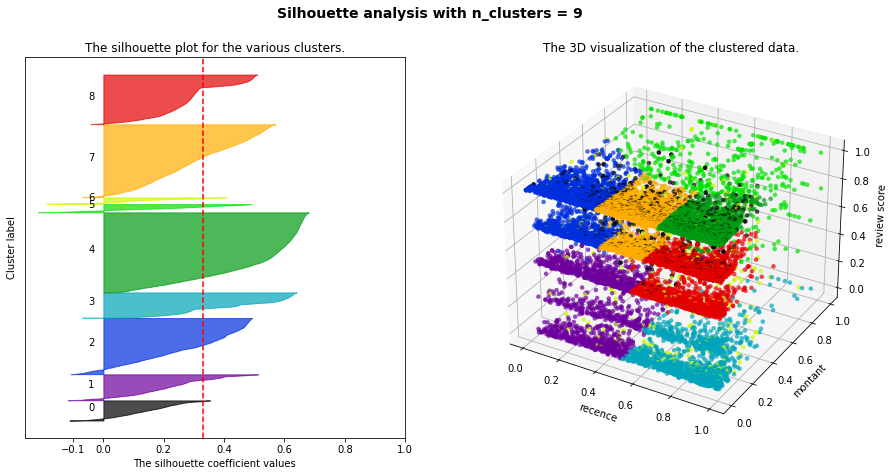

Préparation du modèle K-means avec les données entre 2017-02-01 00:00:00 et 2018-02-01 00:00:00
Silhouette score moyen: 0.329


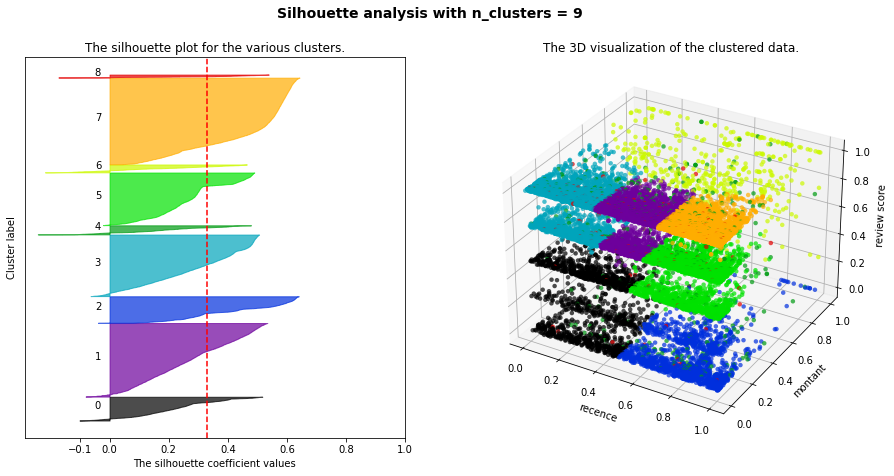

Préparation du modèle K-means avec les données entre 2017-03-01 00:00:00 et 2018-03-01 00:00:00
Silhouette score moyen: 0.333


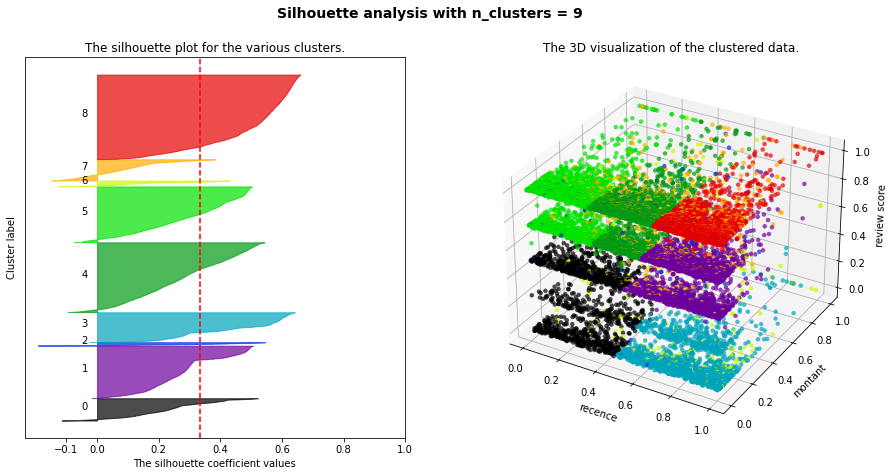

Préparation du modèle K-means avec les données entre 2017-04-01 00:00:00 et 2018-04-01 00:00:00
Silhouette score moyen: 0.321


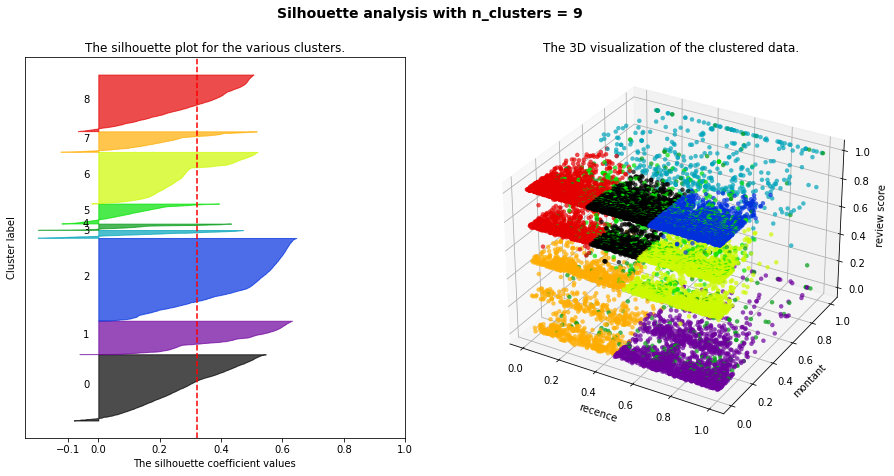

Préparation du modèle K-means avec les données entre 2017-05-01 00:00:00 et 2018-05-01 00:00:00
Silhouette score moyen: 0.325


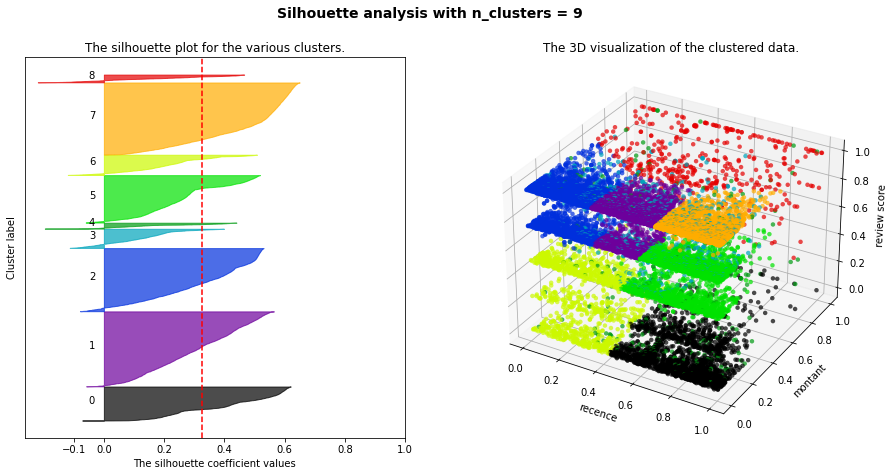

Préparation du modèle K-means avec les données entre 2017-06-01 00:00:00 et 2018-06-01 00:00:00
Silhouette score moyen: 0.320


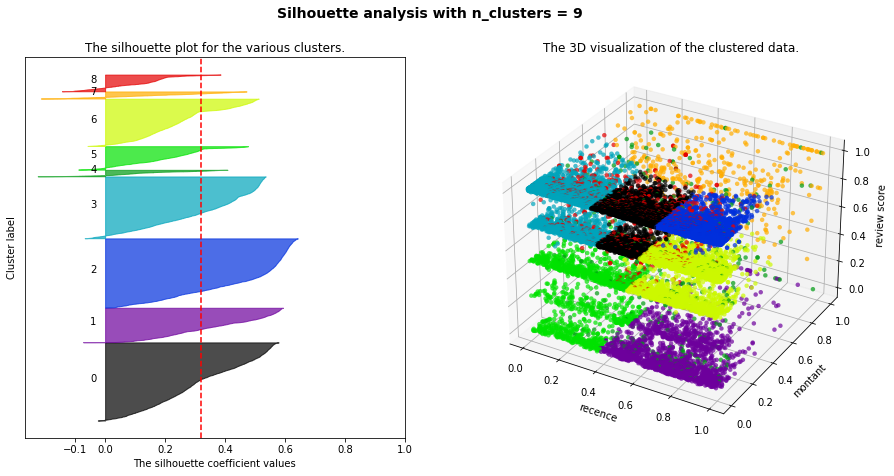

Préparation du modèle K-means avec les données entre 2017-07-01 00:00:00 et 2018-07-01 00:00:00
Silhouette score moyen: 0.311


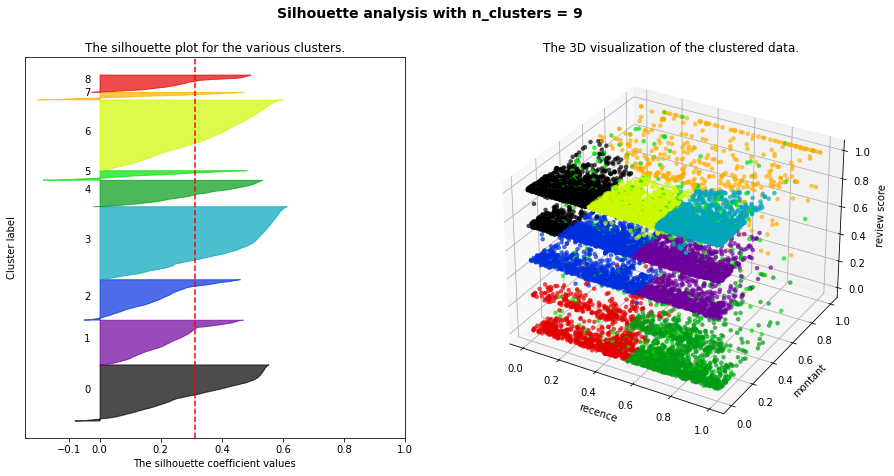

Préparation du modèle K-means avec les données entre 2017-08-01 00:00:00 et 2018-08-01 00:00:00
Silhouette score moyen: 0.299


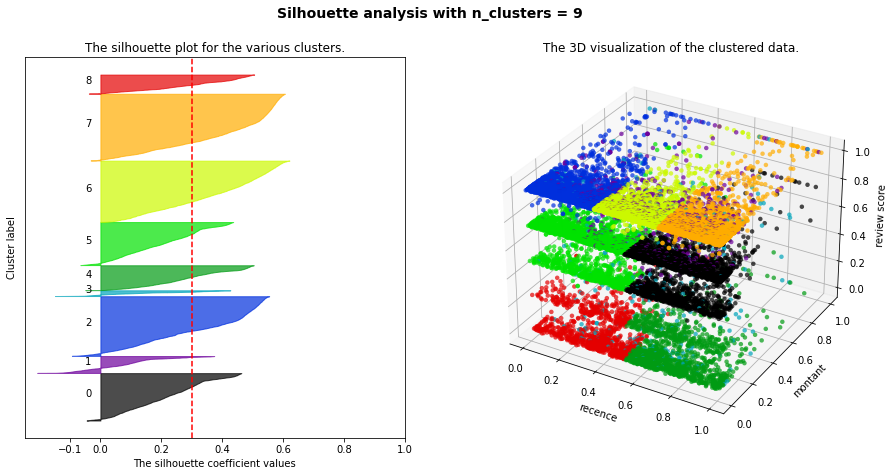

Préparation du modèle K-means avec les données entre 2017-09-01 00:00:00 et 2018-09-01 00:00:00
Silhouette score moyen: 0.304


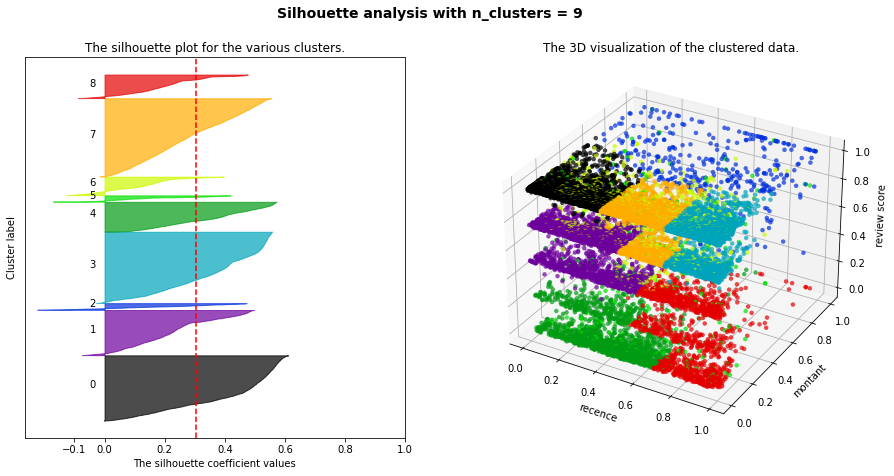

In [18]:
TemporalModels = {}
for i in range(month_steps):
    # since = since_date
    since = since_date + relativedelta(months=+i)
    until = until_date + relativedelta(months=+i)
    print(f"Préparation du modèle K-means avec les données entre {since} et {until}")
    TemporalModels[f"M{i}"] = plot_silhouette(KMeans(n_clusters=nb_clusters, random_state=random_seed), TemporalDataSets[f"D{i}"])

---
---
# 4. Regardons les changements<a class="anchor" id="prepare_scores"></a> [⇪](#menu)


In [19]:
from sklearn.metrics import adjusted_rand_score

In [20]:
rand_scores = []
for i in range(0,month_steps):
    since = since_date + relativedelta(months=+i)
    until = until_date + relativedelta(months=+i)

    predA = TemporalModels['M0'].predict(TemporalDataSets_0[f'D{i}'])
    predB = TemporalModels[f'M{i}'].predict(TemporalDataSets[f'D{i}'])

    rand_score = adjusted_rand_score(predA, predB)
    rand_scores.append(rand_score)

    print(f"M0_D{i} vs M{i}_D{i} = {rand_score:.5f} (+{i} mois)")

M0_D0 vs M0_D0 = 1.00000 (+0 mois)
M0_D1 vs M1_D1 = 0.86584 (+1 mois)
M0_D2 vs M2_D2 = 0.82665 (+2 mois)
M0_D3 vs M3_D3 = 0.76054 (+3 mois)
M0_D4 vs M4_D4 = 0.85333 (+4 mois)
M0_D5 vs M5_D5 = 0.84471 (+5 mois)
M0_D6 vs M6_D6 = 0.68001 (+6 mois)
M0_D7 vs M7_D7 = 0.70159 (+7 mois)
M0_D8 vs M8_D8 = 0.61636 (+8 mois)


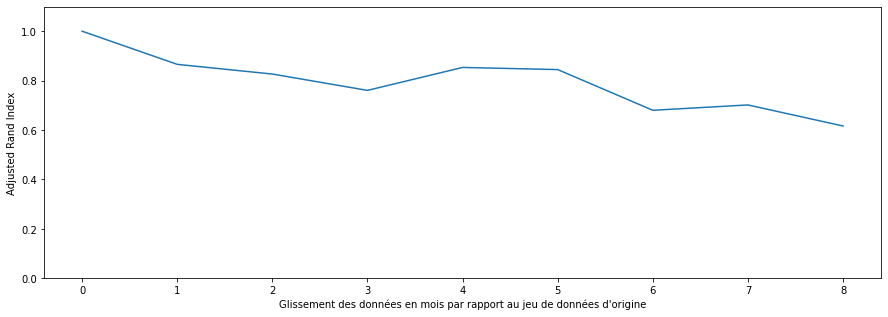

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

In [22]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting

## 9 clusters / 20K samples / en remplaçant les outliers (0.995)

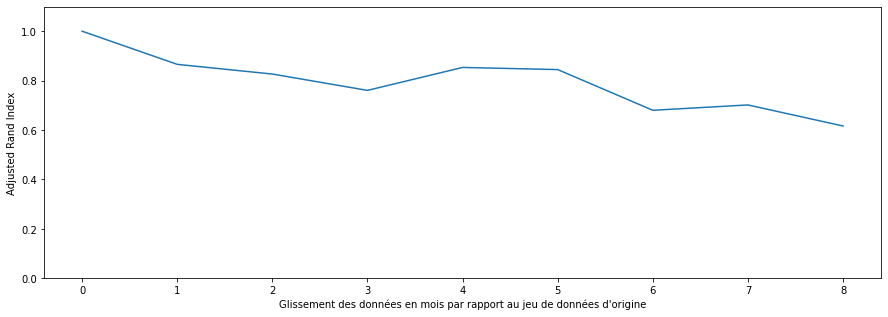

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 9 clusters / 20K samples / en remplaçant les outliers (0.99)

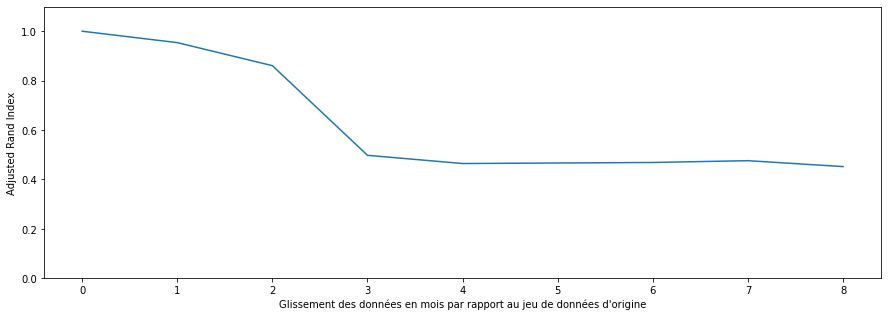

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 4 clusters / 20K samples / en remplaçant les outliers (0.999)

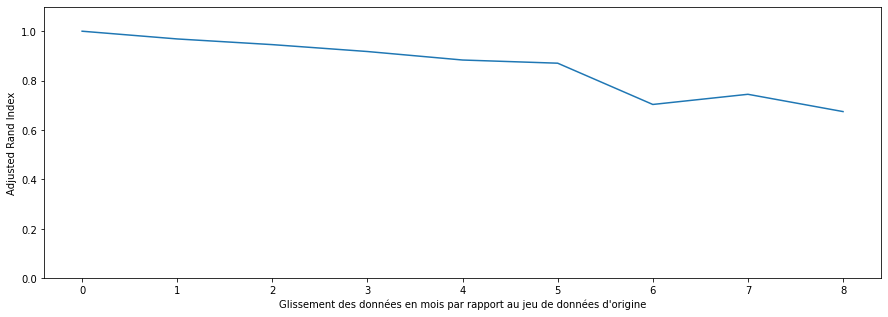

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 9 clusters / 20K samples / en remplaçant les outliers (0.999)

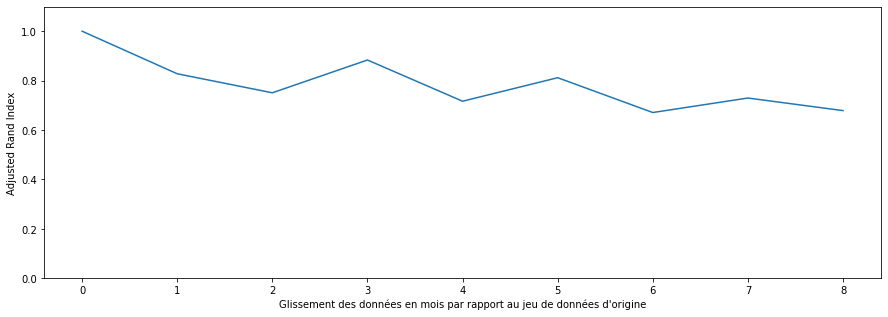

In [34]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 9 clusters / 20K samples / sans les outliers montant (le reste oui) à 0.999

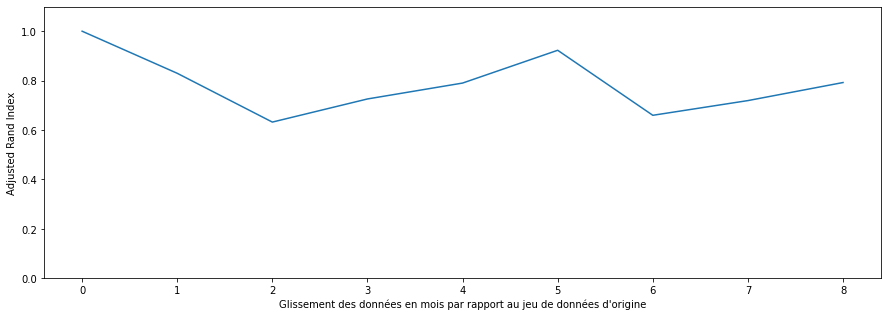

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 4 clusters / 20K samples / sans les outliers montant (le reste oui) à 0.999

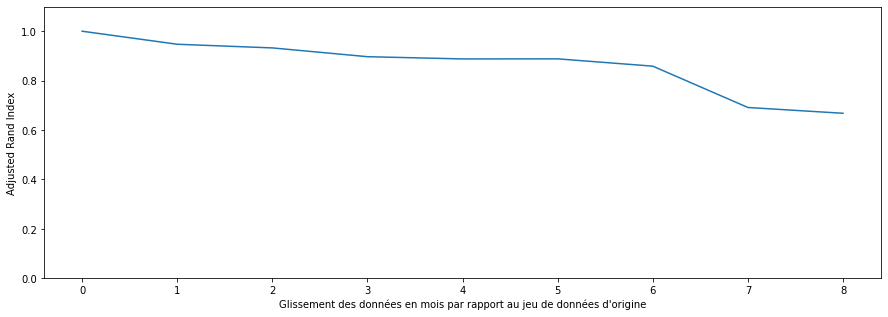

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 4 clusters / 18K samples / sans les outliers à 0.999

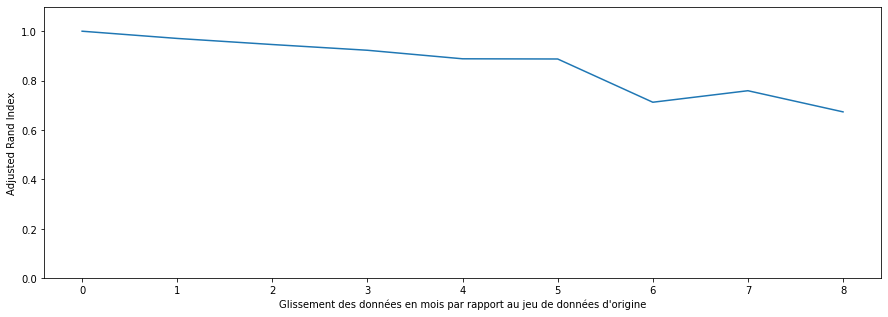

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 4 clusters / 20K samples / sans les outliers à 0.999

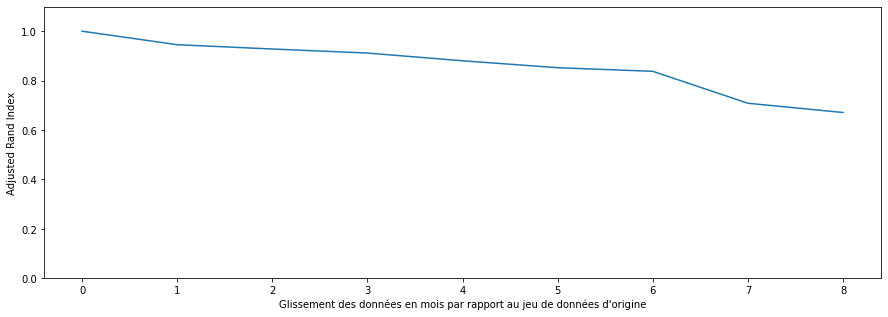

In [92]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

## 4 clusters / 20K samples / avec les outliers (sauf montant = 0)

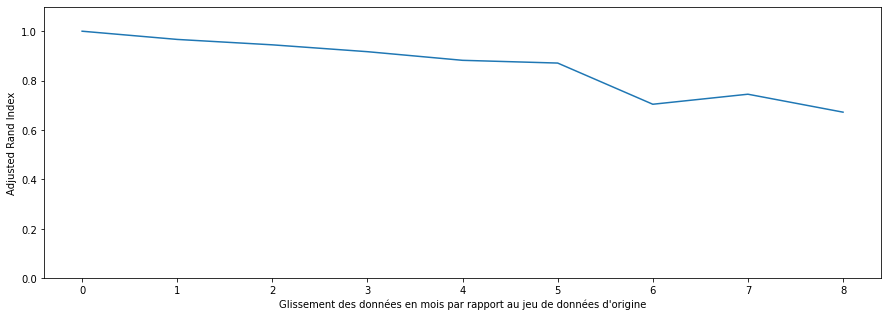

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rand_scores)
plt.ylim([0,1.1])
plt.xlabel("Glissement des données en mois par rapport au jeu de données d'origine")
plt.ylabel("Adjusted Rand Index")
plt.show()

---
---
# 5. Evidently<a class="anchor" id="evidently"></a> [⇪](#menu)


In [ ]:
from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab, ProbClassificationPerformanceTab, ClassificationPerformanceTab

from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

In [ ]:
#datetime = 'dteday'
numerical_features = TemporalDataSets['T0'].columns

In [ ]:
column_mapping = ColumnMapping(
    #target,
    'prediction',
    #datetime=datetime,
    task='clustering',
    numerical_features=numerical_features,
    #categorical_features=categorical_features
)

In [ ]:
dashboard = Dashboard(tabs=[DataQualityTab()])

In [ ]:
dashboard.calculate(TemporalDataSets['T0'], TemporalDataSets['T8'], column_mapping=column_mapping)

In [ ]:
dashboard.save('reports/datadrift.html')

In [ ]:
dashboard.show(mode='inline')

In [ ]:
T_labels = pd.DataFrame(TemporalModels['M0'].predict(TemporalDataSets['T0']), columns=['target'])
P_labels = pd.DataFrame(TemporalModels['M0'].predict(TemporalDataSets['T0']), columns=['prediction'])
model_ref = pd.concat([TemporalDataSets['T0'], T_labels], axis=1)
model_ref = pd.concat([model_ref, P_labels], axis=1)
model_ref.head(2)

In [ ]:
P_labels = pd.DataFrame(TemporalModels['M0'].predict(TemporalDataSets['T8']), columns=['prediction'])
model_new = pd.concat([TemporalDataSets['T0'], T_labels], axis=1)
model_new = pd.concat([model_new, P_labels], axis=1)
model_new.head(2)

In [ ]:
dashboard = Dashboard(tabs=[ClassificationPerformanceTab()])

In [ ]:
column_mapping = ColumnMapping(
    target='target',
    prediction='prediction',
    #datetime=datetime,
    task='clustering',
    #numerical_features=numerical_features,
    #categorical_features=categorical_features
)

In [ ]:
dashboard.calculate(model_ref, model_new, column_mapping=column_mapping)

In [ ]:
dashboard.show(mode='inline')

In [ ]:
dashboard.save('reports/models.html')

In [ ]:
import FreeMobileSMS as sms
sms.send()